# Denoising autoencoder

Modified from https://github.com/eugeniaring/Pytorch-tutorial/blob/main/denAE.ipynb

In [1]:
# Imports
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
from random import sample
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST

## Download MNIST and show some samples

In [2]:
# Download training and testset of MNIST
train_dataset = MNIST('../../data', train=True, download=True, transform=transforms.ToTensor())
val_dataset = MNIST('../../data', train=False, download=True, transform=transforms.ToTensor())

In [3]:
# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512)

## Define the autoencoder

In [4]:
# Autoencoder class
class AutoEncoder(nn.Module):

    def __init__(self, img_size, code_size):
        super().__init__()
        self.img_size = img_size

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(3*3*32, code_size)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(code_size, 3*3*32),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    # Forward pass
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x.reshape(-1, 1, self.img_size, self.img_size)

## Initialize model, loss and optimizer

In [5]:
# Set params
img_size = 28
code_size = 8

# Create model
model = AutoEncoder(img_size, code_size)

# Set training device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set model to device
model.to(device)

# Define loss function
loss_fn = torch.nn.MSELoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train model

In [6]:
# Function to add noise to images
def add_noise(inputs, noise_factor=0.3):
    noise = inputs + noise_factor * torch.randn_like(inputs)
    noise = torch.clip(noise, 0., 1.)
    return noise

In [7]:
# Set training params
num_epochs = 10
noise_factor = 0.3

# Init results
train_losses = []
val_losses = []

# Loop over all epochs
for epoch in range(num_epochs):

    # Set model to train
    model.train()
    
    # Loop over all batches
    for image_batch, _ in tqdm(train_loader):

        # Add noise to image
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(device)

        # Predict denoised image
        denoised_data = model(image_noisy)

        # Compute error between original image and predicted image
        loss = loss_fn(denoised_data, image_batch.to(device))

        # Step optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Append results
        train_losses.append(loss.detach().cpu().numpy())

    # Set model to evaluate
    model.eval()

    # Loop over all batches
    epoch_val_losses = []
    for image_batch, _ in tqdm(val_loader):

        # Add noise to image
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(device)

        # Predict denoised image
        with torch.no_grad(): denoised_data = model(image_noisy)

        # Compute error between original image and predicted image
        val_loss = loss_fn(denoised_data, image_batch.to(device))

        # Append results
        epoch_val_losses.append(val_loss.cpu().numpy())

    # Append validation losses
    val_losses.append(np.mean(epoch_val_losses))

  0%|                                                                                                                                                       | 0/118 [00:00<?, ?it/s]

  1%|█▏                                                                                                                                             | 1/118 [00:00<01:03,  1.85it/s]

  3%|████▊                                                                                                                                          | 4/118 [00:00<00:16,  7.05it/s]

  6%|████████▍                                                                                                                                      | 7/118 [00:00<00:10, 11.00it/s]

  8%|████████████                                                                                                                                  | 10/118 [00:01<00:08, 12.36it/s]

 11%|███████████████▋                                                                                                                              | 13/118 [00:01<00:07, 14.85it/s]

 14%|███████████████████▎                                                                                                                          | 16/118 [00:01<00:06, 16.56it/s]

 16%|██████████████████████▊                                                                                                                       | 19/118 [00:01<00:05, 17.93it/s]

 18%|█████████████████████████▎                                                                                                                    | 21/118 [00:01<00:05, 18.25it/s]

 20%|████████████████████████████▉                                                                                                                 | 24/118 [00:01<00:04, 19.13it/s]

 23%|████████████████████████████████▍                                                                                                             | 27/118 [00:01<00:04, 19.10it/s]

 25%|████████████████████████████████████                                                                                                          | 30/118 [00:01<00:04, 19.73it/s]

 28%|███████████████████████████████████████▋                                                                                                      | 33/118 [00:02<00:04, 20.43it/s]

 31%|███████████████████████████████████████████▎                                                                                                  | 36/118 [00:02<00:03, 20.79it/s]

 33%|██████████████████████████████████████████████▉                                                                                               | 39/118 [00:02<00:03, 21.01it/s]

 36%|██████████████████████████████████████████████████▌                                                                                           | 42/118 [00:02<00:03, 20.74it/s]

 38%|██████████████████████████████████████████████████████▏                                                                                       | 45/118 [00:02<00:03, 20.96it/s]

 41%|█████████████████████████████████████████████████████████▊                                                                                    | 48/118 [00:02<00:03, 21.21it/s]

 43%|█████████████████████████████████████████████████████████████▎                                                                                | 51/118 [00:02<00:03, 21.47it/s]

 46%|████████████████████████████████████████████████████████████████▉                                                                             | 54/118 [00:03<00:02, 21.37it/s]

 48%|████████████████████████████████████████████████████████████████████▌                                                                         | 57/118 [00:03<00:02, 21.32it/s]

 51%|████████████████████████████████████████████████████████████████████████▏                                                                     | 60/118 [00:03<00:02, 20.83it/s]

 53%|███████████████████████████████████████████████████████████████████████████▊                                                                  | 63/118 [00:03<00:02, 21.15it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▍                                                              | 66/118 [00:03<00:02, 21.27it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████                                                           | 69/118 [00:03<00:02, 20.77it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                       | 72/118 [00:03<00:02, 21.06it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 75/118 [00:04<00:02, 20.80it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 78/118 [00:04<00:01, 21.08it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 81/118 [00:04<00:01, 21.31it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 84/118 [00:04<00:01, 21.40it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 87/118 [00:04<00:01, 21.31it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 90/118 [00:04<00:01, 21.41it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 93/118 [00:04<00:01, 21.47it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 96/118 [00:05<00:01, 21.48it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 99/118 [00:05<00:00, 21.12it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 102/118 [00:05<00:00, 21.32it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 105/118 [00:05<00:00, 21.33it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 108/118 [00:05<00:00, 21.81it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 111/118 [00:05<00:00, 21.79it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 114/118 [00:05<00:00, 22.34it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 117/118 [00:06<00:00, 22.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:06<00:00, 19.29it/s]

  0%|                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 15%|█████████████████████▌                                                                                                                          | 3/20 [00:00<00:00, 22.45it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 6/20 [00:00<00:00, 23.29it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                               | 9/20 [00:00<00:00, 23.59it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 12/20 [00:00<00:00, 23.91it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 15/20 [00:00<00:00, 23.11it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 18/20 [00:00<00:00, 22.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 23.35it/s]

  0%|                                                                                                                                                       | 0/118 [00:00<?, ?it/s]

  3%|███▋                                                                                                                                           | 3/118 [00:00<00:05, 21.09it/s]

  5%|███████▎                                                                                                                                       | 6/118 [00:00<00:05, 21.29it/s]

  8%|██████████▉                                                                                                                                    | 9/118 [00:00<00:05, 21.31it/s]

 10%|██████████████▍                                                                                                                               | 12/118 [00:00<00:04, 21.73it/s]

 13%|██████████████████                                                                                                                            | 15/118 [00:00<00:04, 22.24it/s]

 15%|█████████████████████▋                                                                                                                        | 18/118 [00:00<00:04, 21.71it/s]

 18%|█████████████████████████▎                                                                                                                    | 21/118 [00:00<00:04, 21.68it/s]

 20%|████████████████████████████▉                                                                                                                 | 24/118 [00:01<00:04, 21.42it/s]

 23%|████████████████████████████████▍                                                                                                             | 27/118 [00:01<00:04, 21.17it/s]

 25%|████████████████████████████████████                                                                                                          | 30/118 [00:01<00:04, 21.22it/s]

 28%|███████████████████████████████████████▋                                                                                                      | 33/118 [00:01<00:04, 20.97it/s]

 31%|███████████████████████████████████████████▎                                                                                                  | 36/118 [00:01<00:03, 20.84it/s]

 33%|██████████████████████████████████████████████▉                                                                                               | 39/118 [00:01<00:03, 21.17it/s]

 36%|██████████████████████████████████████████████████▌                                                                                           | 42/118 [00:01<00:03, 20.81it/s]

 38%|██████████████████████████████████████████████████████▏                                                                                       | 45/118 [00:02<00:03, 20.77it/s]

 41%|█████████████████████████████████████████████████████████▊                                                                                    | 48/118 [00:02<00:03, 19.32it/s]

 43%|█████████████████████████████████████████████████████████████▎                                                                                | 51/118 [00:02<00:03, 20.04it/s]

 46%|████████████████████████████████████████████████████████████████▉                                                                             | 54/118 [00:02<00:03, 20.54it/s]

 48%|████████████████████████████████████████████████████████████████████▌                                                                         | 57/118 [00:02<00:02, 21.19it/s]

 51%|████████████████████████████████████████████████████████████████████████▏                                                                     | 60/118 [00:02<00:02, 21.79it/s]

 53%|███████████████████████████████████████████████████████████████████████████▊                                                                  | 63/118 [00:02<00:02, 21.94it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▍                                                              | 66/118 [00:03<00:02, 21.56it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████                                                           | 69/118 [00:03<00:02, 20.41it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                       | 72/118 [00:03<00:02, 20.68it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 75/118 [00:03<00:02, 20.68it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 78/118 [00:03<00:01, 20.91it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 81/118 [00:03<00:01, 20.76it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 84/118 [00:04<00:01, 20.55it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 87/118 [00:04<00:01, 20.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 90/118 [00:04<00:01, 19.44it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 92/118 [00:04<00:01, 19.52it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 95/118 [00:04<00:01, 19.57it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 97/118 [00:04<00:01, 18.67it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 99/118 [00:04<00:01, 18.57it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 101/118 [00:04<00:00, 18.81it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 104/118 [00:05<00:00, 19.40it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 107/118 [00:05<00:00, 19.22it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 109/118 [00:05<00:00, 18.58it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 111/118 [00:05<00:00, 18.82it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 113/118 [00:05<00:00, 18.93it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 115/118 [00:05<00:00, 18.70it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 117/118 [00:05<00:00, 18.92it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:05<00:00, 20.45it/s]

  0%|                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 15%|█████████████████████▌                                                                                                                          | 3/20 [00:00<00:00, 22.22it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 6/20 [00:00<00:00, 21.30it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                               | 9/20 [00:00<00:00, 19.71it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▋                                                                | 11/20 [00:00<00:00, 17.86it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13/20 [00:00<00:00, 18.07it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 15/20 [00:00<00:00, 16.71it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 17/20 [00:00<00:00, 15.64it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 19/20 [00:01<00:00, 15.71it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.63it/s]

  0%|                                                                                                                                                       | 0/118 [00:00<?, ?it/s]

  2%|██▍                                                                                                                                            | 2/118 [00:00<00:08, 13.76it/s]

  3%|████▊                                                                                                                                          | 4/118 [00:00<00:08, 12.90it/s]

  5%|███████▎                                                                                                                                       | 6/118 [00:00<00:09, 11.79it/s]

  7%|█████████▋                                                                                                                                     | 8/118 [00:00<00:08, 12.55it/s]

  8%|████████████                                                                                                                                  | 10/118 [00:00<00:08, 12.74it/s]

 10%|██████████████▍                                                                                                                               | 12/118 [00:00<00:08, 13.20it/s]

 12%|████████████████▊                                                                                                                             | 14/118 [00:01<00:07, 13.53it/s]

 14%|███████████████████▎                                                                                                                          | 16/118 [00:01<00:07, 13.58it/s]

 15%|█████████████████████▋                                                                                                                        | 18/118 [00:01<00:07, 13.05it/s]

 17%|████████████████████████                                                                                                                      | 20/118 [00:01<00:07, 13.44it/s]

 19%|██████████████████████████▍                                                                                                                   | 22/118 [00:01<00:07, 13.64it/s]

 20%|████████████████████████████▉                                                                                                                 | 24/118 [00:01<00:06, 13.46it/s]

 22%|███████████████████████████████▎                                                                                                              | 26/118 [00:01<00:06, 13.76it/s]

 24%|█████████████████████████████████▋                                                                                                            | 28/118 [00:02<00:06, 13.94it/s]

 25%|████████████████████████████████████                                                                                                          | 30/118 [00:02<00:06, 14.02it/s]

 27%|██████████████████████████████████████▌                                                                                                       | 32/118 [00:02<00:06, 13.19it/s]

 29%|████████████████████████████████████████▉                                                                                                     | 34/118 [00:02<00:06, 13.47it/s]

 31%|███████████████████████████████████████████▎                                                                                                  | 36/118 [00:02<00:05, 13.78it/s]

 32%|█████████████████████████████████████████████▋                                                                                                | 38/118 [00:02<00:05, 13.60it/s]

 34%|████████████████████████████████████████████████▏                                                                                             | 40/118 [00:02<00:05, 13.63it/s]

 36%|██████████████████████████████████████████████████▌                                                                                           | 42/118 [00:03<00:05, 13.86it/s]

 37%|████████████████████████████████████████████████████▉                                                                                         | 44/118 [00:03<00:05, 14.02it/s]

 39%|███████████████████████████████████████████████████████▎                                                                                      | 46/118 [00:03<00:05, 13.22it/s]

 41%|█████████████████████████████████████████████████████████▊                                                                                    | 48/118 [00:03<00:05, 13.54it/s]

 42%|████████████████████████████████████████████████████████████▏                                                                                 | 50/118 [00:03<00:05, 13.09it/s]

 44%|██████████████████████████████████████████████████████████████▌                                                                               | 52/118 [00:03<00:04, 13.51it/s]

 46%|████████████████████████████████████████████████████████████████▉                                                                             | 54/118 [00:04<00:04, 13.77it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                          | 56/118 [00:04<00:04, 13.87it/s]

 49%|█████████████████████████████████████████████████████████████████████▊                                                                        | 58/118 [00:04<00:04, 13.95it/s]

 51%|████████████████████████████████████████████████████████████████████████▏                                                                     | 60/118 [00:04<00:04, 13.05it/s]

 53%|██████████████████████████████████████████████████████████████████████████▌                                                                   | 62/118 [00:04<00:04, 13.42it/s]

 54%|█████████████████████████████████████████████████████████████████████████████                                                                 | 64/118 [00:04<00:03, 13.57it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▍                                                              | 66/118 [00:04<00:03, 13.51it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▊                                                            | 68/118 [00:05<00:03, 13.51it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▏                                                         | 70/118 [00:05<00:04, 11.76it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                       | 72/118 [00:05<00:03, 11.83it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████                                                     | 74/118 [00:05<00:03, 12.62it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 76/118 [00:05<00:03, 13.12it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 78/118 [00:05<00:02, 13.42it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 80/118 [00:05<00:02, 13.72it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 82/118 [00:06<00:02, 13.96it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 84/118 [00:06<00:02, 14.14it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 86/118 [00:06<00:02, 14.28it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 88/118 [00:06<00:02, 13.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 90/118 [00:06<00:02, 13.49it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 92/118 [00:06<00:01, 13.92it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 94/118 [00:06<00:01, 14.18it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 96/118 [00:07<00:01, 14.25it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 98/118 [00:07<00:01, 14.31it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 100/118 [00:07<00:01, 14.45it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 102/118 [00:07<00:01, 13.75it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 104/118 [00:07<00:01, 13.94it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 106/118 [00:07<00:00, 13.78it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 108/118 [00:07<00:00, 13.94it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 110/118 [00:08<00:00, 14.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 112/118 [00:08<00:00, 14.18it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 114/118 [00:08<00:00, 13.64it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 116/118 [00:08<00:00, 13.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.64it/s]

  0%|                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 10%|██████████████▍                                                                                                                                 | 2/20 [00:00<00:01, 12.90it/s]

 20%|████████████████████████████▊                                                                                                                   | 4/20 [00:00<00:01, 12.81it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 6/20 [00:00<00:01, 13.10it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 8/20 [00:00<00:00, 13.26it/s]

 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 10/20 [00:00<00:00, 12.75it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 12/20 [00:00<00:00, 12.13it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14/20 [00:01<00:00, 12.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16/20 [00:01<00:00, 12.58it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 18/20 [00:01<00:00, 12.94it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.08it/s]

  0%|                                                                                                                                                       | 0/118 [00:00<?, ?it/s]

  1%|█▏                                                                                                                                             | 1/118 [00:00<00:12,  9.23it/s]

  3%|███▋                                                                                                                                           | 3/118 [00:00<00:09, 12.19it/s]

  4%|██████                                                                                                                                         | 5/118 [00:00<00:09, 12.07it/s]

  6%|████████▍                                                                                                                                      | 7/118 [00:00<00:08, 13.00it/s]

  8%|██████████▉                                                                                                                                    | 9/118 [00:00<00:08, 13.06it/s]

  9%|█████████████▏                                                                                                                                | 11/118 [00:00<00:08, 12.99it/s]

 11%|███████████████▋                                                                                                                              | 13/118 [00:01<00:07, 13.31it/s]

 13%|██████████████████                                                                                                                            | 15/118 [00:01<00:07, 13.73it/s]

 14%|████████████████████▍                                                                                                                         | 17/118 [00:01<00:07, 13.91it/s]

 16%|██████████████████████▊                                                                                                                       | 19/118 [00:01<00:07, 13.46it/s]

 18%|█████████████████████████▎                                                                                                                    | 21/118 [00:01<00:07, 13.72it/s]

 19%|███████████████████████████▋                                                                                                                  | 23/118 [00:01<00:06, 13.70it/s]

 21%|██████████████████████████████                                                                                                                | 25/118 [00:01<00:06, 13.96it/s]

 23%|████████████████████████████████▍                                                                                                             | 27/118 [00:02<00:06, 14.00it/s]

 25%|██████████████████████████████████▉                                                                                                           | 29/118 [00:02<00:06, 14.16it/s]

 26%|█████████████████████████████████████▎                                                                                                        | 31/118 [00:02<00:06, 14.26it/s]

 28%|███████████████████████████████████████▋                                                                                                      | 33/118 [00:02<00:06, 13.33it/s]

 30%|██████████████████████████████████████████                                                                                                    | 35/118 [00:02<00:06, 13.57it/s]

 31%|████████████████████████████████████████████▌                                                                                                 | 37/118 [00:02<00:06, 13.40it/s]

 33%|██████████████████████████████████████████████▉                                                                                               | 39/118 [00:02<00:05, 13.83it/s]

 35%|█████████████████████████████████████████████████▎                                                                                            | 41/118 [00:03<00:05, 13.97it/s]

 36%|███████████████████████████████████████████████████▋                                                                                          | 43/118 [00:03<00:05, 14.18it/s]

 38%|██████████████████████████████████████████████████████▏                                                                                       | 45/118 [00:03<00:05, 13.91it/s]

 40%|████████████████████████████████████████████████████████▌                                                                                     | 47/118 [00:03<00:05, 13.55it/s]

 42%|██████████████████████████████████████████████████████████▉                                                                                   | 49/118 [00:03<00:04, 13.87it/s]

 43%|█████████████████████████████████████████████████████████████▎                                                                                | 51/118 [00:03<00:04, 13.44it/s]

 45%|███████████████████████████████████████████████████████████████▊                                                                              | 53/118 [00:03<00:04, 13.57it/s]

 47%|██████████████████████████████████████████████████████████████████▏                                                                           | 55/118 [00:04<00:05, 12.08it/s]

 48%|████████████████████████████████████████████████████████████████████▌                                                                         | 57/118 [00:04<00:04, 12.85it/s]

 50%|███████████████████████████████████████████████████████████████████████                                                                       | 59/118 [00:04<00:04, 13.05it/s]

 52%|█████████████████████████████████████████████████████████████████████████▍                                                                    | 61/118 [00:04<00:04, 13.46it/s]

 53%|███████████████████████████████████████████████████████████████████████████▊                                                                  | 63/118 [00:04<00:03, 13.75it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▏                                                               | 65/118 [00:04<00:03, 13.91it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▋                                                             | 67/118 [00:04<00:03, 14.15it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████                                                           | 69/118 [00:05<00:03, 14.33it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                        | 71/118 [00:05<00:03, 14.41it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▊                                                      | 73/118 [00:05<00:03, 13.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 75/118 [00:05<00:03, 14.12it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 77/118 [00:05<00:02, 14.30it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████                                               | 79/118 [00:05<00:02, 14.24it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 81/118 [00:05<00:02, 14.47it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 83/118 [00:06<00:02, 14.60it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 85/118 [00:06<00:02, 14.67it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 87/118 [00:06<00:02, 14.66it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 89/118 [00:06<00:02, 13.86it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 91/118 [00:06<00:01, 13.67it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 93/118 [00:06<00:01, 14.06it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 95/118 [00:06<00:01, 13.68it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 97/118 [00:07<00:01, 14.00it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 99/118 [00:07<00:01, 14.24it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 101/118 [00:07<00:01, 14.38it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 103/118 [00:07<00:01, 13.46it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 105/118 [00:07<00:00, 13.71it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 107/118 [00:07<00:00, 14.04it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 109/118 [00:07<00:00, 13.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 111/118 [00:08<00:00, 14.07it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 113/118 [00:08<00:00, 14.29it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 115/118 [00:08<00:00, 14.36it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 117/118 [00:08<00:00, 13.57it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.84it/s]

  0%|                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 10%|██████████████▍                                                                                                                                 | 2/20 [00:00<00:00, 18.47it/s]

 20%|████████████████████████████▊                                                                                                                   | 4/20 [00:00<00:00, 18.22it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 6/20 [00:00<00:00, 17.42it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 8/20 [00:00<00:00, 15.63it/s]

 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 10/20 [00:00<00:00, 14.84it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 12/20 [00:00<00:00, 12.82it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14/20 [00:01<00:00, 12.44it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16/20 [00:01<00:00, 12.44it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 18/20 [00:01<00:00, 13.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.60it/s]

  0%|                                                                                                                                                       | 0/118 [00:00<?, ?it/s]

  2%|██▍                                                                                                                                            | 2/118 [00:00<00:08, 13.36it/s]

  3%|████▊                                                                                                                                          | 4/118 [00:00<00:08, 14.22it/s]

  5%|███████▎                                                                                                                                       | 6/118 [00:00<00:07, 14.35it/s]

  7%|█████████▋                                                                                                                                     | 8/118 [00:00<00:07, 14.25it/s]

  8%|████████████                                                                                                                                  | 10/118 [00:00<00:07, 14.25it/s]

 10%|██████████████▍                                                                                                                               | 12/118 [00:00<00:07, 14.27it/s]

 12%|████████████████▊                                                                                                                             | 14/118 [00:00<00:07, 14.15it/s]

 14%|███████████████████▎                                                                                                                          | 16/118 [00:01<00:07, 13.92it/s]

 15%|█████████████████████▋                                                                                                                        | 18/118 [00:01<00:07, 14.15it/s]

 17%|████████████████████████                                                                                                                      | 20/118 [00:01<00:06, 14.26it/s]

 19%|██████████████████████████▍                                                                                                                   | 22/118 [00:01<00:07, 13.30it/s]

 20%|████████████████████████████▉                                                                                                                 | 24/118 [00:01<00:08, 11.65it/s]

 22%|███████████████████████████████▎                                                                                                              | 26/118 [00:01<00:07, 12.44it/s]

 24%|█████████████████████████████████▋                                                                                                            | 28/118 [00:02<00:07, 12.83it/s]

 25%|████████████████████████████████████                                                                                                          | 30/118 [00:02<00:06, 13.17it/s]

 27%|██████████████████████████████████████▌                                                                                                       | 32/118 [00:02<00:06, 13.61it/s]

 29%|████████████████████████████████████████▉                                                                                                     | 34/118 [00:02<00:06, 13.98it/s]

 31%|███████████████████████████████████████████▎                                                                                                  | 36/118 [00:02<00:06, 13.21it/s]

 32%|█████████████████████████████████████████████▋                                                                                                | 38/118 [00:02<00:05, 13.58it/s]

 34%|████████████████████████████████████████████████▏                                                                                             | 40/118 [00:02<00:05, 13.91it/s]

 36%|██████████████████████████████████████████████████▌                                                                                           | 42/118 [00:03<00:05, 13.82it/s]

 37%|████████████████████████████████████████████████████▉                                                                                         | 44/118 [00:03<00:05, 14.13it/s]

 39%|███████████████████████████████████████████████████████▎                                                                                      | 46/118 [00:03<00:05, 14.37it/s]

 41%|█████████████████████████████████████████████████████████▊                                                                                    | 48/118 [00:03<00:04, 14.54it/s]

 42%|████████████████████████████████████████████████████████████▏                                                                                 | 50/118 [00:03<00:04, 13.61it/s]

 44%|██████████████████████████████████████████████████████████████▌                                                                               | 52/118 [00:03<00:04, 13.98it/s]

 46%|████████████████████████████████████████████████████████████████▉                                                                             | 54/118 [00:03<00:04, 14.18it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                          | 56/118 [00:04<00:04, 14.02it/s]

 49%|█████████████████████████████████████████████████████████████████████▊                                                                        | 58/118 [00:04<00:04, 14.21it/s]

 51%|████████████████████████████████████████████████████████████████████████▏                                                                     | 60/118 [00:04<00:04, 14.37it/s]

 53%|██████████████████████████████████████████████████████████████████████████▌                                                                   | 62/118 [00:04<00:03, 14.44it/s]

 54%|█████████████████████████████████████████████████████████████████████████████                                                                 | 64/118 [00:04<00:03, 14.42it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▍                                                              | 66/118 [00:04<00:03, 14.50it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▊                                                            | 68/118 [00:04<00:03, 14.60it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▏                                                         | 70/118 [00:05<00:03, 14.60it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                       | 72/118 [00:05<00:03, 14.30it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████                                                     | 74/118 [00:05<00:03, 14.49it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 76/118 [00:05<00:02, 14.56it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 78/118 [00:05<00:03, 13.32it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 80/118 [00:05<00:02, 13.67it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 82/118 [00:05<00:02, 14.00it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 84/118 [00:06<00:02, 14.15it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 86/118 [00:06<00:02, 13.96it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 88/118 [00:06<00:02, 14.27it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 90/118 [00:06<00:01, 14.44it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 92/118 [00:06<00:01, 13.37it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 94/118 [00:06<00:01, 13.39it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 96/118 [00:06<00:01, 13.76it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 98/118 [00:07<00:01, 13.91it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 100/118 [00:07<00:01, 13.75it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 102/118 [00:07<00:01, 14.00it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 104/118 [00:07<00:00, 14.24it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 106/118 [00:07<00:00, 13.36it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 108/118 [00:07<00:00, 13.73it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 110/118 [00:07<00:00, 13.98it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 112/118 [00:08<00:00, 14.13it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 114/118 [00:08<00:00, 14.13it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 116/118 [00:08<00:00, 14.19it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 14.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.95it/s]

  0%|                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 10%|██████████████▍                                                                                                                                 | 2/20 [00:00<00:01, 12.26it/s]

 20%|████████████████████████████▊                                                                                                                   | 4/20 [00:00<00:01, 14.96it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 6/20 [00:00<00:00, 16.61it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 8/20 [00:00<00:00, 17.44it/s]

 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 10/20 [00:00<00:00, 18.12it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 12/20 [00:00<00:00, 17.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14/20 [00:00<00:00, 18.17it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16/20 [00:00<00:00, 17.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 18/20 [00:01<00:00, 18.21it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.94it/s]

  0%|                                                                                                                                                       | 0/118 [00:00<?, ?it/s]

  2%|██▍                                                                                                                                            | 2/118 [00:00<00:09, 11.91it/s]

  3%|████▊                                                                                                                                          | 4/118 [00:00<00:08, 13.48it/s]

  5%|███████▎                                                                                                                                       | 6/118 [00:00<00:07, 14.21it/s]

  7%|█████████▋                                                                                                                                     | 8/118 [00:00<00:07, 14.55it/s]

  8%|████████████                                                                                                                                  | 10/118 [00:00<00:07, 14.18it/s]

 10%|██████████████▍                                                                                                                               | 12/118 [00:00<00:07, 14.38it/s]

 12%|████████████████▊                                                                                                                             | 14/118 [00:00<00:07, 14.59it/s]

 14%|███████████████████▎                                                                                                                          | 16/118 [00:01<00:07, 13.52it/s]

 15%|█████████████████████▋                                                                                                                        | 18/118 [00:01<00:07, 13.89it/s]

 17%|████████████████████████                                                                                                                      | 20/118 [00:01<00:06, 14.14it/s]

 19%|██████████████████████████▍                                                                                                                   | 22/118 [00:01<00:06, 14.24it/s]

 20%|████████████████████████████▉                                                                                                                 | 24/118 [00:01<00:06, 13.84it/s]

 22%|███████████████████████████████▎                                                                                                              | 26/118 [00:01<00:06, 14.03it/s]

 24%|█████████████████████████████████▋                                                                                                            | 28/118 [00:01<00:06, 14.27it/s]

 25%|████████████████████████████████████                                                                                                          | 30/118 [00:02<00:06, 13.62it/s]

 27%|██████████████████████████████████████▌                                                                                                       | 32/118 [00:02<00:06, 13.86it/s]

 29%|████████████████████████████████████████▉                                                                                                     | 34/118 [00:02<00:05, 14.14it/s]

 31%|███████████████████████████████████████████▎                                                                                                  | 36/118 [00:02<00:05, 14.25it/s]

 32%|█████████████████████████████████████████████▋                                                                                                | 38/118 [00:02<00:05, 13.82it/s]

 34%|████████████████████████████████████████████████▏                                                                                             | 40/118 [00:02<00:05, 14.01it/s]

 36%|██████████████████████████████████████████████████▌                                                                                           | 42/118 [00:02<00:05, 14.19it/s]

 37%|████████████████████████████████████████████████████▉                                                                                         | 44/118 [00:03<00:05, 13.34it/s]

 39%|███████████████████████████████████████████████████████▎                                                                                      | 46/118 [00:03<00:05, 12.13it/s]

 41%|█████████████████████████████████████████████████████████▊                                                                                    | 48/118 [00:03<00:05, 12.43it/s]

 42%|████████████████████████████████████████████████████████████▏                                                                                 | 50/118 [00:03<00:05, 12.71it/s]

 44%|██████████████████████████████████████████████████████████████▌                                                                               | 52/118 [00:03<00:04, 13.28it/s]

 46%|████████████████████████████████████████████████████████████████▉                                                                             | 54/118 [00:03<00:04, 13.71it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                          | 56/118 [00:04<00:04, 13.12it/s]

 49%|█████████████████████████████████████████████████████████████████████▊                                                                        | 58/118 [00:04<00:04, 13.59it/s]

 51%|████████████████████████████████████████████████████████████████████████▏                                                                     | 60/118 [00:04<00:04, 13.94it/s]

 53%|██████████████████████████████████████████████████████████████████████████▌                                                                   | 62/118 [00:04<00:03, 14.20it/s]

 54%|█████████████████████████████████████████████████████████████████████████████                                                                 | 64/118 [00:04<00:03, 14.24it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▍                                                              | 66/118 [00:04<00:03, 14.36it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▊                                                            | 68/118 [00:04<00:03, 14.43it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▏                                                         | 70/118 [00:05<00:03, 14.12it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                       | 72/118 [00:05<00:03, 13.45it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████                                                     | 74/118 [00:05<00:03, 13.47it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 76/118 [00:05<00:03, 12.05it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 78/118 [00:05<00:03, 12.52it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 80/118 [00:05<00:02, 13.12it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 82/118 [00:06<00:02, 13.60it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 84/118 [00:06<00:02, 13.00it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 86/118 [00:06<00:02, 13.47it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 88/118 [00:06<00:02, 13.88it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 90/118 [00:06<00:01, 14.10it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 92/118 [00:06<00:01, 14.03it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 94/118 [00:06<00:01, 14.07it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 96/118 [00:06<00:01, 14.27it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 98/118 [00:07<00:01, 13.23it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 100/118 [00:07<00:01, 13.70it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 102/118 [00:07<00:01, 14.02it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 104/118 [00:07<00:00, 14.26it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 106/118 [00:07<00:00, 14.14it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 108/118 [00:07<00:00, 14.26it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 110/118 [00:07<00:00, 14.40it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 112/118 [00:08<00:00, 13.41it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 114/118 [00:08<00:00, 13.79it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 116/118 [00:08<00:00, 14.16it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.85it/s]

  0%|                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 10%|██████████████▍                                                                                                                                 | 2/20 [00:00<00:00, 18.27it/s]

 20%|████████████████████████████▊                                                                                                                   | 4/20 [00:00<00:00, 17.38it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 6/20 [00:00<00:00, 17.64it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 8/20 [00:00<00:00, 17.98it/s]

 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 10/20 [00:00<00:00, 15.62it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 12/20 [00:00<00:00, 14.40it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14/20 [00:00<00:00, 14.13it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16/20 [00:01<00:00, 14.10it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 18/20 [00:01<00:00, 13.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.50it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.04it/s]

  0%|                                                                                                                                                       | 0/118 [00:00<?, ?it/s]

  1%|█▏                                                                                                                                             | 1/118 [00:00<00:12,  9.57it/s]

  2%|██▍                                                                                                                                            | 2/118 [00:00<00:12,  9.28it/s]

  3%|███▋                                                                                                                                           | 3/118 [00:00<00:13,  8.52it/s]

  4%|██████                                                                                                                                         | 5/118 [00:00<00:10, 11.20it/s]

  6%|████████▍                                                                                                                                      | 7/118 [00:00<00:08, 12.51it/s]

  8%|██████████▉                                                                                                                                    | 9/118 [00:00<00:08, 13.36it/s]

  9%|█████████████▏                                                                                                                                | 11/118 [00:00<00:07, 13.84it/s]

 11%|███████████████▋                                                                                                                              | 13/118 [00:01<00:07, 13.58it/s]

 13%|██████████████████                                                                                                                            | 15/118 [00:01<00:07, 13.97it/s]

 14%|████████████████████▍                                                                                                                         | 17/118 [00:01<00:07, 13.14it/s]

 16%|██████████████████████▊                                                                                                                       | 19/118 [00:01<00:07, 13.57it/s]

 18%|█████████████████████████▎                                                                                                                    | 21/118 [00:01<00:07, 13.77it/s]

 19%|███████████████████████████▋                                                                                                                  | 23/118 [00:01<00:06, 13.91it/s]

 21%|██████████████████████████████                                                                                                                | 25/118 [00:01<00:06, 14.01it/s]

 23%|████████████████████████████████▍                                                                                                             | 27/118 [00:02<00:06, 14.07it/s]

 25%|██████████████████████████████████▉                                                                                                           | 29/118 [00:02<00:06, 14.20it/s]

 26%|█████████████████████████████████████▎                                                                                                        | 31/118 [00:02<00:06, 13.22it/s]

 28%|███████████████████████████████████████▋                                                                                                      | 33/118 [00:02<00:06, 13.58it/s]

 30%|██████████████████████████████████████████                                                                                                    | 35/118 [00:02<00:06, 13.44it/s]

 31%|████████████████████████████████████████████▌                                                                                                 | 37/118 [00:02<00:05, 13.77it/s]

 33%|██████████████████████████████████████████████▉                                                                                               | 39/118 [00:02<00:05, 14.00it/s]

 35%|█████████████████████████████████████████████████▎                                                                                            | 41/118 [00:03<00:05, 13.91it/s]

 36%|███████████████████████████████████████████████████▋                                                                                          | 43/118 [00:03<00:05, 14.14it/s]

 38%|██████████████████████████████████████████████████████▏                                                                                       | 45/118 [00:03<00:05, 13.27it/s]

 40%|████████████████████████████████████████████████████████▌                                                                                     | 47/118 [00:03<00:05, 13.67it/s]

 42%|██████████████████████████████████████████████████████████▉                                                                                   | 49/118 [00:03<00:04, 13.82it/s]

 43%|█████████████████████████████████████████████████████████████▎                                                                                | 51/118 [00:03<00:04, 14.11it/s]

 45%|███████████████████████████████████████████████████████████████▊                                                                              | 53/118 [00:03<00:04, 14.25it/s]

 47%|██████████████████████████████████████████████████████████████████▏                                                                           | 55/118 [00:04<00:04, 14.09it/s]

 48%|████████████████████████████████████████████████████████████████████▌                                                                         | 57/118 [00:04<00:04, 14.27it/s]

 50%|███████████████████████████████████████████████████████████████████████                                                                       | 59/118 [00:04<00:04, 13.47it/s]

 52%|█████████████████████████████████████████████████████████████████████████▍                                                                    | 61/118 [00:04<00:04, 13.85it/s]

 53%|███████████████████████████████████████████████████████████████████████████▊                                                                  | 63/118 [00:04<00:03, 14.08it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▏                                                               | 65/118 [00:04<00:03, 14.23it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▋                                                             | 67/118 [00:04<00:03, 14.39it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████                                                           | 69/118 [00:05<00:03, 13.97it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                        | 71/118 [00:05<00:03, 13.90it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▊                                                      | 73/118 [00:05<00:03, 13.07it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 75/118 [00:05<00:03, 13.37it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 77/118 [00:05<00:02, 13.78it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████                                               | 79/118 [00:05<00:02, 14.04it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 81/118 [00:05<00:02, 14.30it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 83/118 [00:06<00:02, 14.23it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 85/118 [00:06<00:02, 14.34it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 87/118 [00:06<00:02, 13.58it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 89/118 [00:06<00:02, 13.94it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 91/118 [00:06<00:01, 14.11it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 93/118 [00:06<00:01, 14.23it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 95/118 [00:06<00:01, 14.33it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 97/118 [00:07<00:01, 14.32it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 99/118 [00:07<00:01, 14.32it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 101/118 [00:07<00:01, 14.12it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 103/118 [00:07<00:01, 14.28it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 105/118 [00:07<00:00, 14.42it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 107/118 [00:07<00:00, 14.35it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 109/118 [00:07<00:00, 14.44it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 111/118 [00:08<00:00, 14.32it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 113/118 [00:08<00:00, 13.29it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 115/118 [00:08<00:00, 11.67it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 117/118 [00:08<00:00, 12.41it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.73it/s]

  0%|                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 10%|██████████████▍                                                                                                                                 | 2/20 [00:00<00:00, 18.60it/s]

 20%|████████████████████████████▊                                                                                                                   | 4/20 [00:00<00:00, 18.67it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 6/20 [00:00<00:00, 17.09it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 8/20 [00:00<00:00, 17.22it/s]

 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 10/20 [00:00<00:00, 17.73it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 12/20 [00:00<00:00, 18.17it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14/20 [00:00<00:00, 16.49it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16/20 [00:00<00:00, 17.09it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 18/20 [00:01<00:00, 17.07it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.76it/s]

  0%|                                                                                                                                                       | 0/118 [00:00<?, ?it/s]

  2%|██▍                                                                                                                                            | 2/118 [00:00<00:07, 14.61it/s]

  3%|████▊                                                                                                                                          | 4/118 [00:00<00:07, 14.47it/s]

  5%|███████▎                                                                                                                                       | 6/118 [00:00<00:07, 14.30it/s]

  7%|█████████▋                                                                                                                                     | 8/118 [00:00<00:07, 14.53it/s]

  8%|████████████                                                                                                                                  | 10/118 [00:00<00:08, 13.31it/s]

 10%|██████████████▍                                                                                                                               | 12/118 [00:00<00:07, 13.60it/s]

 12%|████████████████▊                                                                                                                             | 14/118 [00:00<00:07, 14.03it/s]

 14%|███████████████████▎                                                                                                                          | 16/118 [00:01<00:07, 14.21it/s]

 15%|█████████████████████▋                                                                                                                        | 18/118 [00:01<00:06, 14.32it/s]

 17%|████████████████████████                                                                                                                      | 20/118 [00:01<00:06, 14.49it/s]

 19%|██████████████████████████▍                                                                                                                   | 22/118 [00:01<00:06, 14.62it/s]

 20%|████████████████████████████▉                                                                                                                 | 24/118 [00:01<00:06, 13.82it/s]

 22%|███████████████████████████████▎                                                                                                              | 26/118 [00:01<00:06, 14.10it/s]

 24%|█████████████████████████████████▋                                                                                                            | 28/118 [00:01<00:06, 14.31it/s]

 25%|████████████████████████████████████                                                                                                          | 30/118 [00:02<00:06, 14.44it/s]

 27%|██████████████████████████████████████▌                                                                                                       | 32/118 [00:02<00:05, 14.54it/s]

 29%|████████████████████████████████████████▉                                                                                                     | 34/118 [00:02<00:05, 14.14it/s]

 31%|███████████████████████████████████████████▎                                                                                                  | 36/118 [00:02<00:05, 14.37it/s]

 32%|█████████████████████████████████████████████▋                                                                                                | 38/118 [00:02<00:05, 14.33it/s]

 34%|████████████████████████████████████████████████▏                                                                                             | 40/118 [00:02<00:05, 13.56it/s]

 36%|██████████████████████████████████████████████████▌                                                                                           | 42/118 [00:02<00:05, 13.83it/s]

 37%|████████████████████████████████████████████████████▉                                                                                         | 44/118 [00:03<00:05, 14.09it/s]

 39%|███████████████████████████████████████████████████████▎                                                                                      | 46/118 [00:03<00:05, 14.31it/s]

 41%|█████████████████████████████████████████████████████████▊                                                                                    | 48/118 [00:03<00:04, 14.43it/s]

 42%|████████████████████████████████████████████████████████████▏                                                                                 | 50/118 [00:03<00:04, 14.63it/s]

 44%|██████████████████████████████████████████████████████████████▌                                                                               | 52/118 [00:03<00:04, 14.59it/s]

 46%|████████████████████████████████████████████████████████████████▉                                                                             | 54/118 [00:03<00:04, 13.62it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                          | 56/118 [00:03<00:04, 13.99it/s]

 49%|█████████████████████████████████████████████████████████████████████▊                                                                        | 58/118 [00:04<00:04, 14.24it/s]

 51%|████████████████████████████████████████████████████████████████████████▏                                                                     | 60/118 [00:04<00:04, 14.44it/s]

 53%|██████████████████████████████████████████████████████████████████████████▌                                                                   | 62/118 [00:04<00:03, 14.59it/s]

 54%|█████████████████████████████████████████████████████████████████████████████                                                                 | 64/118 [00:04<00:03, 14.26it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▍                                                              | 66/118 [00:04<00:03, 14.36it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▊                                                            | 68/118 [00:04<00:03, 13.36it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▏                                                         | 70/118 [00:04<00:03, 13.83it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                       | 72/118 [00:05<00:03, 14.19it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████                                                     | 74/118 [00:05<00:03, 14.53it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 76/118 [00:05<00:02, 14.72it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 78/118 [00:05<00:02, 14.54it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 80/118 [00:05<00:02, 14.76it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 82/118 [00:05<00:02, 13.99it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 84/118 [00:05<00:02, 14.35it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 86/118 [00:06<00:02, 14.62it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 88/118 [00:06<00:02, 14.79it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 90/118 [00:06<00:01, 14.96it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 92/118 [00:06<00:01, 15.02it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 94/118 [00:06<00:01, 14.64it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 96/118 [00:06<00:01, 14.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 98/118 [00:06<00:01, 13.95it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 100/118 [00:07<00:01, 14.29it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 102/118 [00:07<00:01, 14.57it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 104/118 [00:07<00:00, 14.75it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 106/118 [00:07<00:00, 14.75it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 108/118 [00:07<00:00, 14.70it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 110/118 [00:07<00:00, 14.37it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 112/118 [00:07<00:00, 13.19it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 114/118 [00:07<00:00, 13.70it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 116/118 [00:08<00:00, 14.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 14.36it/s]

  0%|                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 10%|██████████████▍                                                                                                                                 | 2/20 [00:00<00:00, 19.28it/s]

 20%|████████████████████████████▊                                                                                                                   | 4/20 [00:00<00:00, 19.15it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 6/20 [00:00<00:00, 18.33it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 8/20 [00:00<00:00, 18.71it/s]

 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 10/20 [00:00<00:00, 16.72it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 12/20 [00:00<00:00, 17.38it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14/20 [00:00<00:00, 18.02it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16/20 [00:00<00:00, 17.96it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 18/20 [00:00<00:00, 18.30it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.56it/s]

  0%|                                                                                                                                                       | 0/118 [00:00<?, ?it/s]

  2%|██▍                                                                                                                                            | 2/118 [00:00<00:07, 14.83it/s]

  3%|████▊                                                                                                                                          | 4/118 [00:00<00:08, 13.84it/s]

  5%|███████▎                                                                                                                                       | 6/118 [00:00<00:07, 14.14it/s]

  7%|█████████▋                                                                                                                                     | 8/118 [00:00<00:08, 13.28it/s]

  8%|████████████                                                                                                                                  | 10/118 [00:00<00:07, 13.67it/s]

 10%|██████████████▍                                                                                                                               | 12/118 [00:00<00:08, 11.85it/s]

 12%|████████████████▊                                                                                                                             | 14/118 [00:01<00:08, 12.64it/s]

 14%|███████████████████▎                                                                                                                          | 16/118 [00:01<00:07, 13.21it/s]

 15%|█████████████████████▋                                                                                                                        | 18/118 [00:01<00:07, 13.28it/s]

 17%|████████████████████████                                                                                                                      | 20/118 [00:01<00:07, 12.68it/s]

 19%|██████████████████████████▍                                                                                                                   | 22/118 [00:01<00:07, 13.19it/s]

 20%|████████████████████████████▉                                                                                                                 | 24/118 [00:01<00:06, 13.67it/s]

 22%|███████████████████████████████▎                                                                                                              | 26/118 [00:01<00:06, 14.01it/s]

 24%|█████████████████████████████████▋                                                                                                            | 28/118 [00:02<00:06, 13.82it/s]

 25%|████████████████████████████████████                                                                                                          | 30/118 [00:02<00:06, 13.91it/s]

 27%|██████████████████████████████████████▌                                                                                                       | 32/118 [00:02<00:06, 13.85it/s]

 29%|████████████████████████████████████████▉                                                                                                     | 34/118 [00:02<00:06, 12.96it/s]

 31%|███████████████████████████████████████████▎                                                                                                  | 36/118 [00:02<00:06, 13.39it/s]

 32%|█████████████████████████████████████████████▋                                                                                                | 38/118 [00:02<00:05, 13.80it/s]

 34%|████████████████████████████████████████████████▏                                                                                             | 40/118 [00:02<00:05, 13.92it/s]

 36%|██████████████████████████████████████████████████▌                                                                                           | 42/118 [00:03<00:05, 13.89it/s]

 37%|████████████████████████████████████████████████████▉                                                                                         | 44/118 [00:03<00:05, 14.22it/s]

 39%|███████████████████████████████████████████████████████▎                                                                                      | 46/118 [00:03<00:05, 13.94it/s]

 41%|█████████████████████████████████████████████████████████▊                                                                                    | 48/118 [00:03<00:05, 13.17it/s]

 42%|████████████████████████████████████████████████████████████▏                                                                                 | 50/118 [00:03<00:05, 13.60it/s]

 44%|██████████████████████████████████████████████████████████████▌                                                                               | 52/118 [00:03<00:04, 13.83it/s]

 46%|████████████████████████████████████████████████████████████████▉                                                                             | 54/118 [00:03<00:04, 13.49it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                          | 56/118 [00:04<00:04, 13.86it/s]

 49%|█████████████████████████████████████████████████████████████████████▊                                                                        | 58/118 [00:04<00:04, 14.17it/s]

 51%|████████████████████████████████████████████████████████████████████████▏                                                                     | 60/118 [00:04<00:04, 13.74it/s]

 53%|██████████████████████████████████████████████████████████████████████████▌                                                                   | 62/118 [00:04<00:04, 12.95it/s]

 54%|█████████████████████████████████████████████████████████████████████████████                                                                 | 64/118 [00:04<00:04, 13.40it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▍                                                              | 66/118 [00:04<00:03, 13.74it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▊                                                            | 68/118 [00:05<00:03, 13.94it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▏                                                         | 70/118 [00:05<00:03, 14.15it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                       | 72/118 [00:05<00:03, 14.26it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████                                                     | 74/118 [00:05<00:03, 13.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 76/118 [00:05<00:03, 13.09it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 78/118 [00:05<00:02, 13.54it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 80/118 [00:05<00:02, 13.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 82/118 [00:06<00:02, 12.11it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 84/118 [00:06<00:02, 12.68it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 86/118 [00:06<00:02, 12.97it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 88/118 [00:06<00:02, 12.24it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 90/118 [00:06<00:02, 12.84it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 92/118 [00:06<00:01, 13.36it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 94/118 [00:06<00:01, 13.71it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 96/118 [00:07<00:01, 14.05it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 98/118 [00:07<00:01, 14.34it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 100/118 [00:07<00:01, 14.06it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 102/118 [00:07<00:01, 13.99it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 104/118 [00:07<00:01, 13.47it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 106/118 [00:07<00:00, 13.89it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 108/118 [00:07<00:00, 14.10it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 110/118 [00:08<00:00, 14.26it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 112/118 [00:08<00:00, 14.46it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 114/118 [00:08<00:00, 13.90it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 116/118 [00:08<00:00, 14.21it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 14.90it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.64it/s]

  0%|                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 10%|██████████████▍                                                                                                                                 | 2/20 [00:00<00:00, 18.08it/s]

 20%|████████████████████████████▊                                                                                                                   | 4/20 [00:00<00:00, 18.35it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 6/20 [00:00<00:00, 18.52it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 8/20 [00:00<00:00, 18.24it/s]

 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 10/20 [00:00<00:00, 18.16it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 12/20 [00:00<00:00, 18.25it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14/20 [00:00<00:00, 17.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16/20 [00:00<00:00, 17.85it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 18/20 [00:01<00:00, 16.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.75it/s]

  0%|                                                                                                                                                       | 0/118 [00:00<?, ?it/s]

  2%|██▍                                                                                                                                            | 2/118 [00:00<00:09, 12.60it/s]

  3%|████▊                                                                                                                                          | 4/118 [00:00<00:08, 13.60it/s]

  5%|███████▎                                                                                                                                       | 6/118 [00:00<00:08, 13.99it/s]

  7%|█████████▋                                                                                                                                     | 8/118 [00:00<00:07, 14.27it/s]

  8%|████████████                                                                                                                                  | 10/118 [00:00<00:07, 14.17it/s]

 10%|██████████████▍                                                                                                                               | 12/118 [00:00<00:07, 13.26it/s]

 12%|████████████████▊                                                                                                                             | 14/118 [00:01<00:08, 11.83it/s]

 14%|███████████████████▎                                                                                                                          | 16/118 [00:01<00:08, 12.55it/s]

 15%|█████████████████████▋                                                                                                                        | 18/118 [00:01<00:07, 13.04it/s]

 17%|████████████████████████                                                                                                                      | 20/118 [00:01<00:07, 13.61it/s]

 19%|██████████████████████████▍                                                                                                                   | 22/118 [00:01<00:06, 13.88it/s]

 20%|████████████████████████████▉                                                                                                                 | 24/118 [00:01<00:06, 13.92it/s]

 22%|███████████████████████████████▎                                                                                                              | 26/118 [00:01<00:07, 13.09it/s]

 24%|█████████████████████████████████▋                                                                                                            | 28/118 [00:02<00:06, 13.24it/s]

 25%|████████████████████████████████████                                                                                                          | 30/118 [00:02<00:06, 13.71it/s]

 27%|██████████████████████████████████████▌                                                                                                       | 32/118 [00:02<00:06, 13.20it/s]

 29%|████████████████████████████████████████▉                                                                                                     | 34/118 [00:02<00:06, 13.66it/s]

 31%|███████████████████████████████████████████▎                                                                                                  | 36/118 [00:02<00:05, 13.87it/s]

 32%|█████████████████████████████████████████████▋                                                                                                | 38/118 [00:02<00:05, 13.91it/s]

 34%|████████████████████████████████████████████████▏                                                                                             | 40/118 [00:02<00:05, 13.72it/s]

 36%|██████████████████████████████████████████████████▌                                                                                           | 42/118 [00:03<00:05, 13.95it/s]

 37%|████████████████████████████████████████████████████▉                                                                                         | 44/118 [00:03<00:05, 14.18it/s]

 39%|███████████████████████████████████████████████████████▎                                                                                      | 46/118 [00:03<00:05, 14.29it/s]

 41%|█████████████████████████████████████████████████████████▊                                                                                    | 48/118 [00:03<00:04, 14.41it/s]

 42%|████████████████████████████████████████████████████████████▏                                                                                 | 50/118 [00:03<00:04, 14.58it/s]

 44%|██████████████████████████████████████████████████████████████▌                                                                               | 52/118 [00:03<00:04, 14.15it/s]

 46%|████████████████████████████████████████████████████████████████▉                                                                             | 54/118 [00:03<00:04, 13.22it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                          | 56/118 [00:04<00:04, 13.00it/s]

 49%|█████████████████████████████████████████████████████████████████████▊                                                                        | 58/118 [00:04<00:04, 13.39it/s]

 51%|████████████████████████████████████████████████████████████████████████▏                                                                     | 60/118 [00:04<00:04, 13.75it/s]

 53%|██████████████████████████████████████████████████████████████████████████▌                                                                   | 62/118 [00:04<00:04, 13.94it/s]

 54%|█████████████████████████████████████████████████████████████████████████████                                                                 | 64/118 [00:04<00:03, 14.14it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▍                                                              | 66/118 [00:04<00:03, 13.75it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▊                                                            | 68/118 [00:05<00:03, 13.25it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▏                                                         | 70/118 [00:05<00:03, 13.66it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                       | 72/118 [00:05<00:03, 13.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████                                                     | 74/118 [00:05<00:03, 14.01it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 76/118 [00:05<00:02, 14.23it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 78/118 [00:05<00:02, 14.31it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 80/118 [00:05<00:02, 14.10it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 82/118 [00:06<00:02, 13.26it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 84/118 [00:06<00:02, 13.67it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 86/118 [00:06<00:02, 13.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 88/118 [00:06<00:02, 14.17it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 90/118 [00:06<00:01, 14.28it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 92/118 [00:06<00:01, 14.44it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 94/118 [00:06<00:01, 13.99it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 96/118 [00:07<00:01, 13.28it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 98/118 [00:07<00:01, 13.63it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 100/118 [00:07<00:01, 13.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 102/118 [00:07<00:01, 14.03it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 104/118 [00:07<00:00, 14.21it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 106/118 [00:07<00:00, 14.27it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 108/118 [00:07<00:00, 14.08it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 110/118 [00:08<00:00, 13.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 112/118 [00:08<00:00, 12.51it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 114/118 [00:08<00:00, 12.11it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 116/118 [00:08<00:00, 12.73it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.72it/s]

  0%|                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 10%|██████████████▍                                                                                                                                 | 2/20 [00:00<00:01, 15.30it/s]

 20%|████████████████████████████▊                                                                                                                   | 4/20 [00:00<00:00, 16.09it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 6/20 [00:00<00:00, 14.63it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 8/20 [00:00<00:00, 15.86it/s]

 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 10/20 [00:00<00:00, 16.66it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 12/20 [00:00<00:00, 17.25it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14/20 [00:00<00:00, 17.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16/20 [00:00<00:00, 17.65it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 18/20 [00:01<00:00, 17.72it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.40it/s]

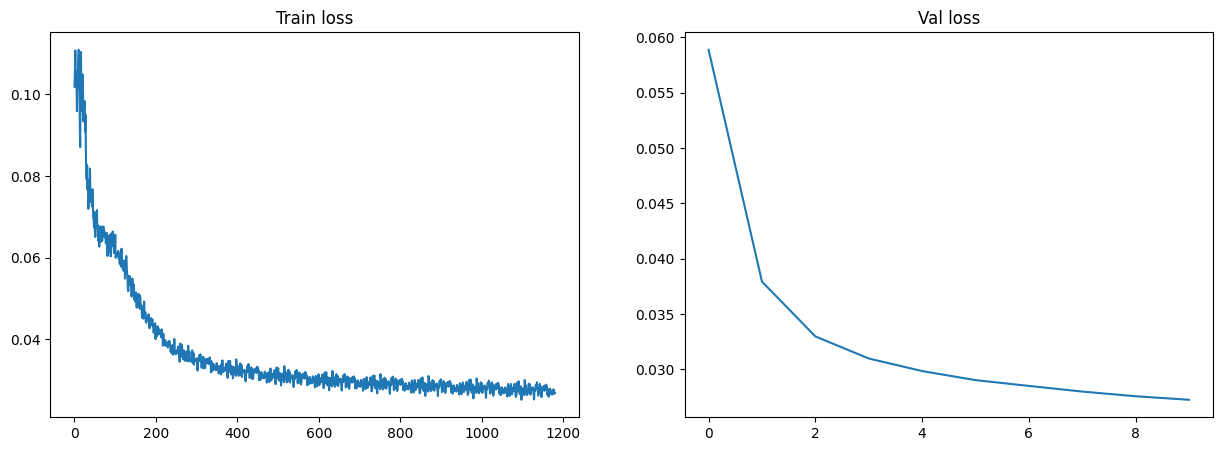

In [8]:
# Plot learning curves
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
axes[0].set_title('Train loss')
axes[0].plot(train_losses)
axes[1].set_title('Val loss')
axes[1].plot(val_losses)


## Model validation

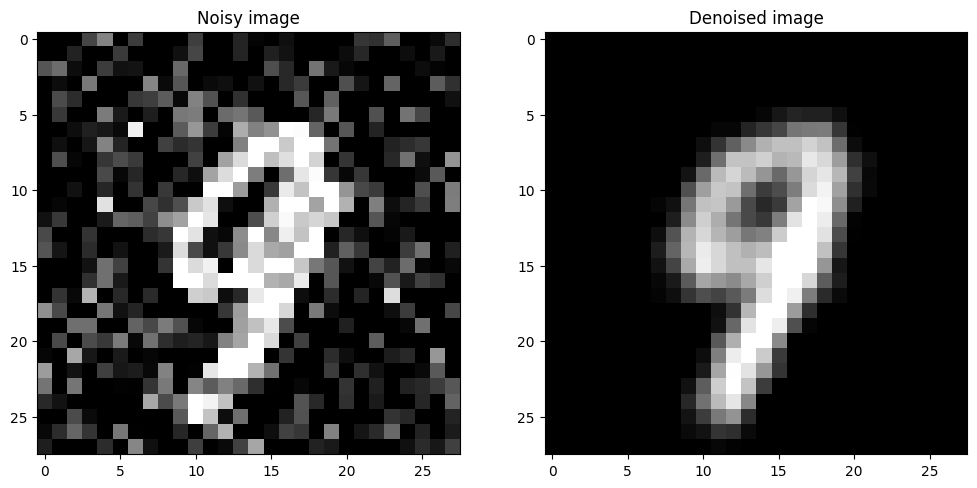

In [9]:
# Get sample
val_img, _ = sample(list(val_dataset), 1)[0]

# Add noise
noisy_val_img = add_noise(val_img)

# Predict denoised image
model.eval()
with torch.no_grad(): output = model(noisy_val_img.to(device)[None, ...])[0, ...]
denoised_val_img = output.clip(0, 1).cpu().numpy()

# Plot sample
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
axes[0].set_title('Noisy image')
axes[0].imshow(noisy_val_img[0], cmap='gray')
axes[1].set_title('Denoised image')
axes[1].imshow(denoised_val_img[0], cmap='gray')